In [1]:
%matplotlib inline
import chainer
from chainer import optimizers, cuda
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
from net import Net

In [8]:
n_epoch = 100 #エポック
batchsize = 100 #バッチサイズ
bprop_len = 100 #何回でバックプロパゲーションを打ち切るか(trancate)
n_units = 200 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = False #GPUを使うかどうか

In [3]:
xp = cuda.cupy if use_gpu is True else np

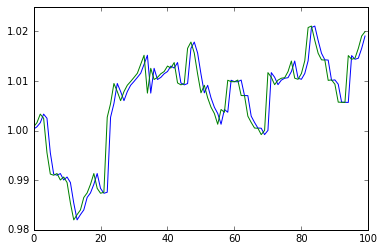

In [5]:
train_data_x = []
train_data_y = []
f = open('30minutes.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    train_data_x.append(row[7])
    train_data_y.append(row[7])
raw_data = np.asarray(train_data_x, dtype=np.float32)
train_data_x = raw_data[:-1]
train_data_y = raw_data[1:]
plt.plot(train_data_x[:100])
plt.plot(train_data_y[:100])

In [6]:
#ネットワークを試す関数
def evaluate(model,num,origin=0):
    t = chainer.Variable(xp.array([[origin]],dtype=np.float32))
    output = []
    evaluator = model.copy()
    evaluator.reset_state()
    for i in range(num):
        t = evaluator.predict(t)
        output.append(t.data[0])
    return output

In [9]:
model = Net(1, n_units)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs]))
    y = chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % 10 == 0:
            print('epoch {}, error {}'.format(epoch, loss_data / length))
        loss.append(loss_data / length)
        loss_data = 0
        model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

epoch 10, error 0.003029694315046072
epoch 20, error 0.00311310775578022
epoch 30, error 0.01236002054065466
epoch 40, error 0.001268397318199277
epoch 50, error 0.000347114255419001
epoch 60, error 6.356952508212999e-05
epoch 70, error 9.561088518239558e-05
epoch 80, error 9.275630145566538e-05
epoch 90, error 0.00016911639249883592
epoch 100, error 0.000333822681568563


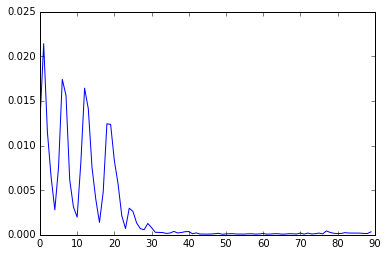

In [11]:
plt.plot(loss[10:])

In [ ]:
output = evaluate(model,10000,origin=1)
plt.plot(output[100:10000])